In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import random
from monai.networks.nets import UNet
from metrics import SSIM
from scipy.ndimage import map_coordinates
from pytorch_lightning.loggers import WandbLogger
import wandb
from scipy.ndimage.morphology import binary_closing, binary_dilation
from skimage.data import shepp_logan_phantom
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from torchvision.transforms import Compose, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, RandomCrop, ToPILImage
import PIL
from PIL import Image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from copy import deepcopy
# for gryds, see: https://github.com/tueimage/gryds
# install with `pip install git+https://github.com/tueimage/gryds`
import gryds
SEED=271828 # int(exp(1) * 10 ** 5)
seed_everything(SEED)


In [2]:
# Globally set the used loss function
# can be either: 'ComplexL1', 'ComplexMSE', or '⟂-Loss'
LOSS_FUNCTION='⟂-Loss'


In [3]:
class PerpLoss(nn.Module):
    """
    SSIM loss module.
    """

    def __init__(self):
        super().__init__()
    def forward(self, X: torch.Tensor, Y: torch.Tensor):
        assert X.is_complex()
        assert Y.is_complex()

        mag_input = torch.abs(X)
        mag_target = torch.abs(Y)
        cross = torch.abs(X.real * Y.imag - X.imag * Y.real)

        angle = torch.atan2(X.imag, X.real) - torch.atan2(Y.imag, Y.real)
        ploss = torch.abs(cross) / (mag_input + 1e-8)

        aligned_mask = (torch.cos(angle) < 0).bool()

        final_term = torch.zeros_like(ploss)
        final_term[aligned_mask] = mag_target[aligned_mask] + (mag_target[aligned_mask] - ploss[aligned_mask])
        final_term[~aligned_mask] = ploss[~aligned_mask]
        return (
        (final_term + F.mse_loss(mag_input, mag_target)).mean()


In [4]:
class SSIM(nn.Module):
    """
    SSIM loss module.
    """

    def __init__(self, win_size: int = 7, k1: float = 0.01, k2: float = 0.03):
        """
        Args:
            win_size: Window size for SSIM calculation.
            k1: k1 parameter for SSIM calculation.
            k2: k2 parameter for SSIM calculation.
        """
        super().__init__()
        self.win_size = win_size
        self.k1, self.k2 = k1, k2
        self.register_buffer("w", torch.ones(1, 1, win_size, win_size) / win_size ** 2)
        NP = win_size ** 2
        self.cov_norm = NP / (NP - 1)

    def forward(self, X: torch.Tensor, Y: torch.Tensor, data_range=None, full=False):
        assert isinstance(self.w, torch.Tensor)

        if X.is_complex():
            X = X.abs()
        if Y.is_complex():
            Y = Y.abs()
        if data_range is None:
            data_range = torch.ones_like(Y) #* Y.max()
            p = (self.win_size - 1)//2
            data_range = data_range[:, :, p:-p, p:-p]
        data_range = data_range[:, None, None, None]
        C1 = (self.k1 * data_range) ** 2
        C2 = (self.k2 * data_range) ** 2
        ux = F.conv2d(X, self.w)  # typing: ignore
        uy = F.conv2d(Y, self.w)  #
        uxx = F.conv2d(X * X, self.w)
        uyy = F.conv2d(Y * Y, self.w)
        uxy = F.conv2d(X * Y, self.w)
        vx = self.cov_norm * (uxx - ux * ux)
        vy = self.cov_norm * (uyy - uy * uy)
        vxy = self.cov_norm * (uxy - ux * uy)
        A1, A2, B1, B2 = (
            2 * ux * uy + C1,
            2 * vxy + C2,
            ux ** 2 + uy ** 2 + C1,
            vx + vy + C2,
        )
        D = B1 * B2
        S = (A1 * A2) / D

        if full:
            return S
        else:
            return S.mean()


In [5]:
def warp_volume(imgs, dvfs):
    # format: 
    # img: shape b, 1, x, y
    # dvf: shape b, 2, x, y
    
    # get NumPy arrays on the CPU instead of pytorch tensors
    if not isinstance(imgs, np.ndarray):
        imgs_numpy = imgs.detach().cpu().numpy()
    else:
        imgs_numpy = imgs
        
    if not isinstance(dvfs, np.ndarray):
        dvfs_numpy = dvfs.detach().cpu().numpy()
    else:
        dvfs_numpy = dvfs
        
    # sanity checks and check assumptions about the shape
    assert(len(imgs_numpy.shape) == 4)
    assert(len(dvfs_numpy.shape) == 4)
    assert(dvfs_numpy.shape[1] == 2)
    assert(imgs_numpy.shape[1] == 1)
    assert(imgs_numpy.shape[0] == dvfs_numpy.shape[0])
    assert(imgs_numpy.shape[2:] == dvfs_numpy.shape[2:])

    b, c, x, y = dvfs_numpy.shape
    xz, yz = (np.meshgrid(range(x), range(y)))
    indices = [yz, xz]
    
    warped_images = np.zeros_like(imgs_numpy)
    for batch in range(b):
        warped_images[batch, ...] = _warp_volume(imgs_numpy[batch, ...].squeeze(), dvfs_numpy[batch, ...].squeeze(), indices)
        
    return torch.from_numpy(warped_images)

def _warp_volume(img, dvf, indices):
    # format: 
    # img: shape    x, y
    # dvf: shape 2, x, y
    
    
    c, x, y = dvf.shape
    newpos = np.zeros((2, x, y))
    for i in range(2):
        # warning! assumes square image!
        assert x == y
        newpos[i, ...] = indices[i] + dvf[i, ...]*x/2

    warped = map_coordinates(img, newpos)
    return warped

In [6]:
class MotionNetwork(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # residual U-Net model
        self.model = UNet(dimensions=2, in_channels=2, out_channels=2, channels=[16, 32, 64, 128, 256], strides=[2, 2, 2, 2], num_res_units=2)
        self.ssim_val = SSIM()
        self.ploss = PerpLoss()
        self.l1_loss = torch.nn.L1Loss()
        self.l2_loss = torch.nn.MSELoss()

    def forward(self, data):  
        return self.model(data)
    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-4)
        sched = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[35, 45], gamma=0.1)
        return [optim], [sched]
    def training_step(self, train_batch, batch_idx):
        img1, img2, target, valid = train_batch
        data = torch.cat((img1, img2), 1)
        
        output = model(data)
        
        dvf_mask = torch.cat((valid, valid), 1).bool()
        output[~dvf_mask] = 0
        target[~dvf_mask] = 0

        # register fixed image to dynamic
        warped = warp_volume(img1, output)
        complex_output = torch.view_as_complex(output.permute(0, 2, 3, 1).contiguous()).squeeze().unsqueeze(1)
        complex_target = torch.view_as_complex(target.permute(0, 2, 3, 1).contiguous()).squeeze().unsqueeze(1)
        complex_l1 = self.l1_loss(complex_output, complex_target)
        complex_loss = self.l2_loss(complex_output.real, complex_target.real) + self.l2_loss(complex_output.imag, complex_target.imag)
        computed_pdist = self.ploss(complex_output, complex_target)
        mag_output = torch.norm(output, p=2, dim=1)
        mag_target = torch.norm(target, p=2, dim=1)
        
        magnitude_ratio = (mag_output - mag_target).mean().item() # 0 if symmetric. Negative if biased towards underesimation
        
        self.log('Train/Complex MSE', complex_loss.item(), on_step=True)
        self.log('Train/Complex L1', complex_l1.item(), on_step=True)
        self.log('Train/⟂-Loss', computed_pdist.item(), on_step=True)
        self.log('Train/Magnitude ratio', magnitude_ratio, on_step=True)
        self.log('Train/Registered SSIM', self.ssim_val(img2.to('cuda'), warped.to('cuda')).item(), on_step=True)

        if LOSS_FUNCTION == 'ComplexL1':
            return complex_l1
        elif LOSS_FUNCTION == 'ComplexMSE':
            return complex_loss
        elif LOSS_FUNCTION == '⟂-Loss':
            return computed_pdist
        else:
            raise ArgumentError(f"I don't know that loss function: {LOSS_FUNCTION}")
    def validation_step(self, val_batch, batch_idx):
        img1, img2, target, valid = val_batch
        data = torch.cat((img1, img2), 1)
        
        output = model(data)
        
        dvf_mask = torch.cat((valid, valid), 1).bool()
        output[~dvf_mask] = 0
        target[~dvf_mask] = 0

        warped = warp_volume(img1, output)
        complex_output = torch.view_as_complex(output.permute(0, 2, 3, 1).contiguous()).squeeze().unsqueeze(1)
        complex_target = torch.view_as_complex(target.permute(0, 2, 3, 1).contiguous()).squeeze().unsqueeze(1)
        complex_l1 = self.l1_loss(complex_output, complex_target)
        complex_loss = self.l2_loss(complex_output.real, complex_target.real) + self.l2_loss(complex_output.imag, complex_target.imag)
        computed_pdist = self.ploss(complex_output, complex_target)
        mag_output = torch.norm(output, p=2, dim=1)
        mag_target = torch.norm(target, p=2, dim=1)
        
        magnitude_ratio = (mag_output - mag_target).mean().item()
        self.log('Validation/Complex MSE', complex_loss.item(), on_step=True)
        self.log('Validation/Complex L1', complex_l1.item(), on_step=True)
        self.log('Validation/⟂-Loss', computed_pdist.item(), on_step=True)
        self.log('Validation/Magnitude ratio', magnitude_ratio, on_step=True)

        self.log('Validation/Registered SSIM', self.ssim_val(img2.to('cuda'), warped.to('cuda')).item(), on_step=True)

        if batch_idx == 0:
            target_images = make_grid(torch.clip(img1.permute((0, 3, 1, 2))[0].unsqueeze(1), 0, 1), nrow=1)
            recon_images = make_grid(torch.clip(img2.permute((0, 3, 1, 2))[0].unsqueeze(1), 0, 1), nrow=1)
            self.logger.experiment.log({'ref_image': [wandb.Image(target_images, caption='Reference image')],
                                        'dyn_image': [wandb.Image(recon_images, caption='Dynamic image')]})

        if LOSS_FUNCTION == 'ComplexL1':
            return complex_l1
        elif LOSS_FUNCTION == 'ComplexMSE':
            return complex_loss
        elif LOSS_FUNCTION == '⟂-Loss':
            return computed_pdist
        else:
            raise ArgumentError(f"I don't know that loss function: {LOSS_FUNCTION}")


In [7]:
class DVFDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, augment=False, tform=None):
        # normally we give the path to the image, but now we use the shepp-logan phantom
        # NOTE: This likely will not work very well
#         self.images = glob(f'{image_folder}/*.npy')
        self.images = [shepp_logan_phantom() for _ in range(200)]
    
        self.augment = augment
        self.tform = tform
        if self.augment:
            assert self.tform is not None
            
    # when generating the mask, simply fill any holes within the anatomy
    def fill_holes(self, img):
        img = deepcopy(img)
        x, y = img.shape
        for i in range(x):
            nonzero = np.asarray(img[i, :] == 1).nonzero()[0]
            if len(nonzero) < 2:
                continue

            img[i, nonzero[0]:nonzero[-1]] = 1

        return img
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if isinstance(self.images[index], str):
            img = np.load(self.images[index])
        else:
            img = self.images[index]
            
        if self.augment:
            img = self.tform(Image.fromarray(img))
            
        image = np.array(img)
        image /= np.max(image)
        mask = self.fill_holes(binary_dilation(binary_closing(image > 0.05))).astype(np.float32)
        x, y = image.shape

        an_image_interpolator = gryds.Interpolator(image, order=1)
        mask_interpolator = gryds.Interpolator(mask.astype(np.float32), order=0)
        # test whether the deformation will fold at any time by inspecting the jacobian determinant
        # Simply retry if it folds. Note: can go into infinite loop if scale range is too high
        folds = True
        while folds:
            folds = False
            spline_basis = 3
            deformation = np.random.randn(2, spline_basis, spline_basis)
            scale = np.random.uniform(0.001, 0.05)
            a_grid = gryds.Grid(image.shape)
            a_bspline_transformation = gryds.BSplineTransformation(scale*deformation)
            jac_det = a_grid.jacobian_det(a_bspline_transformation)
            folds |= any(j <= 0 for jd in jac_det for j in jd)

        # actually generate the warped image by deforming it using the DVF
        a_translated_image_grid = a_grid.transform(a_bspline_transformation)
        a_deformed_image = an_image_interpolator.resample(a_translated_image_grid)
        mask += mask_interpolator.resample(a_translated_image_grid).astype(bool)
        displacement_field = torch.from_numpy((a_translated_image_grid.grid-a_grid.grid) * 2).float()

        # replicate along 2nd dimension 
        dvf_mask = torch.cat((torch.from_numpy(mask).unsqueeze(0), torch.from_numpy(mask).unsqueeze(0)), 0).bool()
        displacement_field[~dvf_mask] = 0
        
        img_tensor = torch.from_numpy(image).unsqueeze(0).float()
        warped_tensor = torch.from_numpy(a_deformed_image).unsqueeze(0).float()
        dvf = displacement_field.float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        return img_tensor, warped_tensor, dvf, mask

In [8]:
train_loader = torch.utils.data.DataLoader(DVFDataset(""), batch_size=16)
fixed, moving, dvf, mask = next(iter(train_loader))


Text(0.5, 1.0, 'Warped image + DVF')

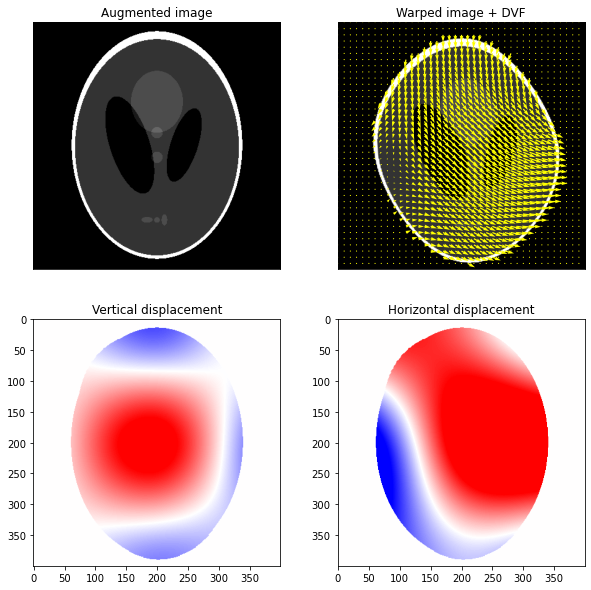

In [13]:

import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(10, 10), squeeze=False)
ax[0, 0].imshow(fixed[1, ...].squeeze().numpy(), vmin=0, vmax=1, cmap='gray')
ax[0, 1].imshow(moving[1, ...].squeeze().numpy(), vmin=0, vmax=1, cmap='gray')
X,Y = np.meshgrid(range(fixed.shape[-2]), range(fixed.shape[-1]))
ax[0, 1].quiver(X[::10,::10], Y[::10,::10],-dvf[1, 1, ...].squeeze().numpy()[::10,::10], dvf[1, 0, ...].squeeze().numpy()[::10,::10], color='yellow', scale=2, width=0.005)
ax[1, 0].imshow(dvf[0, 0, ...].squeeze().numpy(), vmin=-0.05, vmax=0.05, cmap='bwr')
ax[1, 1].imshow(dvf[0, 1, ...].squeeze().numpy(), vmin=-0.05, vmax=0.05, cmap='bwr')

ax[1, 0].set_title('Vertical displacement')
ax[1, 1].set_title('Horizontal displacement')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 0].set_title('Augmented image')
ax[0, 1].set_title('Warped image + DVF')

In [10]:
class DVFDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.tform = Compose([
            RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.75, 1.25), shear=10, resample=PIL.Image.BILINEAR),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomCrop(224)
        ])
        
        self.batch_size = 16
    def setup(self, stage):
        print('>>> Creating train set <<< ')
        self.train = DVFDataset("", augment=True, tform=self.tform)
        print('>>> Creating validation set <<< ')
        self.val = DVFDataset("", augment=False)
        print('>>> Creating test set <<< ')
        self.test = DVFDataset("", augment=False)
                
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, num_workers=24, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=24)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=24)

In [ ]:
data = DVFDataModule()
model = MotionNetwork()
logger = WandbLogger(project='PerpLossDVF', log_model="all")

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else 0, deterministic=True, precision=32, max_epochs=50, logger=logger)

trainer.fit(model, data)